In [1]:
import h2o
from h2o.estimators import H2OIsolationForestEstimator

In [2]:
# Copyright (c) 2020 Uber Technologies, Inc.
# See the License for the specific language governing permissions and
# limitations under the License.
import copy
import os

os.umask(0)
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number

from tqdm import tqdm
import torch
from torch.utils.data import Sampler, DataLoader
import horovod.torch as hvd


from torch.utils.data.distributed import DistributedSampler

from utils import Logger, load_pretrain

from mpi4py import MPI


comm = MPI.COMM_WORLD
hvd.init()
torch.cuda.set_device(hvd.local_rank())

root_path = "/home/erikrozi/LaneGCN"
sys.path.insert(0, root_path)

"""
parser = argparse.ArgumentParser(description="Fuse Detection in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true")
parser.add_argument(
    "--resume", default="", type=str, metavar="RESUME", help="checkpoint path"
)
parser.add_argument(
    "--weight", default="", type=str, metavar="WEIGHT", help="checkpoint path"
)
"""

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def main():
    h2o.init()
    seed = hvd.rank()
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Import all settings for experiment.
    args = dotdict()
    args.model="lanegcn"
    args.eval=False#"store_true"
    args.resume=""
    args.weight="/home/erikrozi/LaneGCN/results/lanegcn/36.000.ckpt"
    
    model = import_module(args.model)
    config, Dataset, collate_fn, net, loss, post_process, opt = model.get_model()

    if config["horovod"]:
        opt.opt = hvd.DistributedOptimizer(
            opt.opt, named_parameters=net.named_parameters()
        )

    if args.resume or args.weight:
        ckpt_path = args.resume or args.weight
        if not os.path.isabs(ckpt_path):
            ckpt_path = os.path.join(config["save_dir"], ckpt_path)
        ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
        load_pretrain(net, ckpt["state_dict"])
        if args.resume:
            config["epoch"] = ckpt["epoch"]
            opt.load_state_dict(ckpt["opt_state"])

    if args.eval:
        # Data loader for evaluation
        dataset = Dataset(config["val_split"], config, train=False)
        val_sampler = DistributedSampler(
            dataset, num_replicas=hvd.size(), rank=hvd.rank()
        )
        val_loader = DataLoader(
            dataset,
            batch_size=config["val_batch_size"],
            num_workers=config["val_workers"],
            sampler=val_sampler,
            collate_fn=collate_fn,
            pin_memory=True,
        )

        hvd.broadcast_parameters(net.state_dict(), root_rank=0)
        val(config, val_loader, net, loss, post_process, 999)
        return

    # Create log and copy all code
    save_dir = config["save_dir"]
    log = os.path.join(save_dir, "log")
    if hvd.rank() == 0:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        sys.stdout = Logger(log)

        src_dirs = [root_path]
        dst_dirs = [os.path.join(save_dir, "files")]
        for src_dir, dst_dir in zip(src_dirs, dst_dirs):
            files = [f for f in os.listdir(src_dir) if f.endswith(".py")]
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)
            for f in files:
                shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

    # Data loader for training
    dataset = Dataset(config["train_split"], config, train=True)
    train_sampler = DistributedSampler(
        dataset, num_replicas=hvd.size(), rank=hvd.rank()
    )
    train_loader = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        sampler=train_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        drop_last=True,
    )
    
    train_loader_not_random = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        sampler=train_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        drop_last=True,
        shuffle=False
    )

    # Data loader for evaluation
    dataset = Dataset(config["val_split"], config, train=False)
    val_sampler = DistributedSampler(dataset, num_replicas=hvd.size(), rank=hvd.rank())
    val_loader = DataLoader(
        dataset,
        batch_size=config["val_batch_size"],
        num_workers=config["val_workers"],
        sampler=val_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    hvd.broadcast_parameters(net.state_dict(), root_rank=0)
    hvd.broadcast_optimizer_state(opt.opt, root_rank=0)

    # Train isolation Forest
    epoch = config["epoch"]
    remaining_epochs = int(np.ceil(config["num_epochs"] - epoch))
    
    output = train_isolation_forest(0, config, train_loader_not_random, net)
    preds = output['isolation_model'].predict(output['training_data'])
    
    # Identify anomolies
    bounds = 5.5
    anomolies = (preds['mean_length']< bounds).as_data_frame().to_numpy().flatten().nonzero()
    non_anomolies = (preds['mean_length']>=bounds).as_data_frame().to_numpy().flatten().nonzero()
    
    non_anomolous_dataset = torch.utils.data.Subset(Dataset(config["train_split"], config, train=True), non_anomolies)
    anomolous_dataset = torch.utils.data.Subset(Dataset(config["train_split"], config, train=True), anomolies)
    
    non_anomolous_train_sampler = DistributedSampler(
        non_anomolous_dataset, num_replicas=hvd.size(), rank=hvd.rank()
    )
    anomolous_train_sampler = DistributedSampler(
        anomolous_dataset, num_replicas=hvd.size(), rank=hvd.rank()
    )
    
    non_anomolous_train_loader = DataLoader(
        non_anomolous_dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        sampler=non_anomolous_train_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        drop_last=True,
    )
    anomolous_train_loader = DataLoader(
        anomolous_dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        sampler=anomolous_train_sampler,
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        drop_last=True,
    )
    
    # reset weights
    config, Dataset, collate_fn, net, loss, post_process, opt = model.get_model()
    
    # Train with non anomolous data
    for i in range(remaining_epochs):
        train(epoch + i, config, non_anomolous_train_loader, net, loss, post_process, opt, val_loader)
        
    # Train with anomolous data
    epoch = config["epoch"]
    remaining_epochs = int(np.ceil(config["num_epochs"] - epoch))
    for i in range(remaining_epochs):
        train(epoch + i, config, anomolous_train_loader, net, loss, post_process, opt, val_loader)
        
        #return train_isolation_forest(epoch + i, config, train_loader_not_random, net)
    
        # Get all anomolies (define upper bound) 
        # Engineer difficulty level and how it gets passed in the model 
        # 
        


def worker_init_fn(pid):
    np_seed = hvd.rank() * 1024 + int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, actors, actor_idcs, actor_ctrs):
        return actors, actor_idcs, actor_ctrs
    
def train_isolation_forest(epoch, config, train_loader, lanegcn_net):
    # convert last layer to identity layer (make copy)
    # save data in eval
    # run isolation model
    # get anomoly labels
    
    #pred_net = copy.deepcopy(lanegcn_net.pred_net)
    
    #lanegcn_net.pred_net = Identity()
    lanegcn_net.config["no_last_layer"] = True
    
    training_data = []
    
    for ii, data in tqdm(enumerate(train_loader),disable=hvd.rank()):
        data = dict(data)
        with torch.no_grad():
            output = lanegcn_net(data)
            out = []
            for i in range(len(output["actor_idcs"])):
                idcs = output["actor_idcs"][i]
                out.append(output["actors"][idcs])
                
            results = [x[0].detach().cpu().numpy() for x in out]
            training_data += results
            
    training_data = np.asarray(training_data)
    np.save(f"results/train_latents_epoch{epoch}.npy", training_data)
    training_data = h2o.H2OFrame(training_data)
    isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", seed = 1234)
    isolation_model.train(training_frame = training_data)
    
    model_path = h2o.save_model(model=isolation_model, path="results/isolation_forest", force=True)
    
    lanegcn_net.config["no_last_layer"] = False
    return {"isolation_model": isolation_model, "training_data": training_data}
    
def train(epoch, config, train_loader, net, loss, post_process, opt, val_loader=None):
    train_loader.sampler.set_epoch(int(epoch))
    net.train()

    num_batches = len(train_loader)
    epoch_per_batch = 1.0 / num_batches
    save_iters = int(np.ceil(config["save_freq"] * num_batches))
    display_iters = int(
        config["display_iters"] / (hvd.size() * config["batch_size"])
    )
    val_iters = int(config["val_iters"] / (hvd.size() * config["batch_size"]))

    start_time = time.time()
    metrics = dict()
    for i, data in tqdm(enumerate(train_loader),disable=hvd.rank()):
        epoch += epoch_per_batch
        data = dict(data)

        output = net(data)
        loss_out = loss(output, data)
        post_out = post_process(output, data)
        post_process.append(metrics, loss_out, post_out)

        opt.zero_grad()
        loss_out["loss"].backward()
        lr = opt.step(epoch)

        num_iters = int(np.round(epoch * num_batches))
        if hvd.rank() == 0 and (
            num_iters % save_iters == 0 or epoch >= config["num_epochs"]
        ):
            save_ckpt(net, opt, config["save_dir"], epoch)

        if num_iters % display_iters == 0:
            dt = time.time() - start_time
            metrics = sync(metrics)
            if hvd.rank() == 0:
                post_process.display(metrics, dt, epoch, lr)
            start_time = time.time()
            metrics = dict()

        if num_iters % val_iters == 0:
            val(config, val_loader, net, loss, post_process, epoch)

        if epoch >= config["num_epochs"]:
            val(config, val_loader, net, loss, post_process, epoch)
            return


def val(config, data_loader, net, loss, post_process, epoch):
    net.eval()

    start_time = time.time()
    metrics = dict()
    for i, data in enumerate(data_loader):
        data = dict(data)
        with torch.no_grad():
            output = net(data)
            loss_out = loss(output, data)
            post_out = post_process(output, data)
            post_process.append(metrics, loss_out, post_out)

    dt = time.time() - start_time
    metrics = sync(metrics)
    if hvd.rank() == 0:
        post_process.display(metrics, dt, epoch)
    net.train()


def save_ckpt(net, opt, save_dir, epoch):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    state_dict = net.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].cpu()

    save_name = "anomolous_%3.3f.ckpt" % epoch
    torch.save(
        {"epoch": epoch, "state_dict": state_dict, "opt_state": opt.opt.state_dict()},
        os.path.join(save_dir, save_name),
    )


def sync(data):
    data_list = comm.allgather(data)
    data = dict()
    for key in data_list[0]:
        if isinstance(data_list[0][key], list):
            data[key] = []
        else:
            data[key] = 0
        for i in range(len(data_list)):
            data[key] += data_list[i][key]
    return data


In [ ]:
output = main()

H2O_cluster_uptime:,48 mins 33 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_erikrozi_ij4jrb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.42 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [7]:
training_data = np.load('/home/erikrozi/LaneGCN/results/train_latents_epoch0.npy', allow_pickle=True)

In [11]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Debian-1deb10u1); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Debian-1deb10u1, mixed mode, sharing)
  Starting server from /home/erikrozi/anaconda3/envs/lanegcn1/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxnxy2q_k
  JVM stdout: /tmp/tmpxnxy2q_k/h2o_erikrozi_started_from_python.out
  JVM stderr: /tmp/tmpxnxy2q_k/h2o_erikrozi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_erikrozi_l15n0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.57 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [12]:
training_data = h2o.H2OFrame(training_data)
isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", seed = 1234)
isolation_model.train(training_frame = training_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
isolationforest Model Build progress: |██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OIsolationForestEstimator : Isolation Forest
Model Key: isolation_forest.hex


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          32873                  8            8            8             22            82            47.28

ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.776825838129865
Normalized Anomaly Score: 0.08145042404016417

Scoring History: 
     timestamp            duration    number_of_trees    mean_tree_path_length    mean_anomaly_score
---  -------------------  ----------  -----------------  -----------------------  --------------------
     2022-12-06 08:15:26  0.031 sec   0.0                nan                      nan
     2022-12-06 08:15:27  0.905 sec   1.0                6.733131071501503        0.05337378569969952
     2022-12-06 08:15:27  1.220 sec   2.0                6.677460473156709        0.058643550335144054
     2022-12-06 08:15:28  1.435 sec   3.0                6.702953830316215        0.05569615681570973
     2022-12-06 08:15:28  1.576 sec   4.0                6.701438391862845        0.05971232162743113
     2022-12-06 08:15:28  1.671 sec   5.0                6.7265660205111955       0.056965412393494425
     2022-12-06 08:15:28  1.786 sec   6.0                6.744155384844483        0.05685435892344901
     2022-12-06 08:15:28  1.889 sec   7.0                6.732324328224035        0.05855405320099448
     2022-12-06 08:15:28  1.977 sec   8.0                6.741670609176777        0.06262530686623703
     2022-12-06 08:15:28  2.049 sec   9.0                6.744617327173901        0.06384566820651887
---  ---                  ---         ---                ---                      ---
     2022-12-06 08:15:30  3.484 sec   27.0               6.7677413966024424       0.07937952268019163
     2022-12-06 08:15:30  3.560 sec   28.0               6.769689059226848        0.0806088292706099
     2022-12-06 08:15:30  3.639 sec   29.0               6.7713583920376434       0.08288258288636116
     2022-12-06 08:15:30  3.712 sec   30.0               6.769745899422693        0.08032119787580003
     2022-12-06 08:15:30  3.786 sec   31.0               6.771384889364544        0.08053486851927533
     2022-12-06 08:15:30  3.860 sec   32.0               6.772666293638672        0.07994152311607153
     2022-12-06 08:15:30  3.937 sec   33.0               6.773103812092563        0.07881657053623019
     2022-12-06 08:15:30  4.009 sec   34.0               6.775809530027962        0.07858222658810962
     2022-12-06 08:15:30  4.083 sec   35.0               6.775720249777166        0.07772070552278494
     2022-12-06 08:15:31  5.162 sec   50.0               6.776825838129865        0.08145042404016417
[37 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [24]:
(isolation_model.predict(training_data)['mean_length'] < 6).as_data_frame().to_numpy().flatten().nonzero()[0].shape

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


(6358,)

In [25]:
(isolation_model.predict(training_data)['mean_length'] >= 6).as_data_frame().to_numpy().flatten().nonzero()[0].shape

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


(199578,)

Closing connection _sid_9702 at exit
H2O session _sid_9702 closed.


In [27]:
(output['isolation_model'].predict(output['training_data'])['mean_length']< 5.5).as_data_frame().to_numpy().flatten().nonzero()

(array([   306,    319,    888, ..., 205122, 205714, 205848]),)

In [32]:
output['training_data']

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128
0,0.0698272,0.306993,0.0440501,0,0.426691,0.595628,0,0,0,0,1.18636,0,1.18098,0.495023,0.460184,0.499608,0,0,0.75192,0,0.84204,1.55551,2.01877,0,0,0,0.158009,0,0,0.446203,0.0933189,0.167921,0,0,5.52953,0.460558,0,0.328253,3.83551,0.00504842,0,0,0.036066,0,0,0.707874,0.269694,0,0.542965,0.0890921,0,0,0,0.534707,0,0,0.146969,0.527501,0,2.71255,0,0.137507,0,0,0,0.121751,0,0,0,0.326248,0.375971,0,0,0,0,0.469143,0.0611706,0,0,0.629414,0,0,0.285088,0.620849,0.439494,0.61764,0.106583,0,0,0.781444,1.03592,0,0,0,0,0,0.0298996,0,4.89025,0,3.17509,0.282107,0,0,0,0,0.134667,0,0.288569,0.0144011,0.0926713,1.44413,0,0,0,0,0.388608,0,0.15858,0.0845693,0,0,0,0,0,0,0
0,0.41522,0.0991731,0,0,0.325102,0,0,0,0,0,1.07654,0,1.71743,0,1.37389,1.6524,0,0,0.625879,0,0.686164,0,5.06604,0,0,0,0.333442,0.0091646,0,1.18383,0,0.0291407,0.612867,0,8.80351,0,0,0.226914,5.77327,0.0596697,0,0,0.534476,0,0.00482327,1.7143,1.74353,0,0.642094,0.519132,0,0,1.41908,0,0,0,0.364422,1.17592,0,5.55449,0,0,0,0,0,0,0,0,0,0,0.253093,0,0,0,0,0.0182688,0.447637,0,0,0.439383,0,0,0.202025,0,0.945621,0.547314,0,0,0.115966,0.139861,1.36208,0,0,0,0.600469,0,0,0,9.19076,0,2.93076,0,0,0,1.54244,0,1.07295,0,0.228279,0.021698,0.146582,2.57739,0,0,0,0,0.0489632,0.187205,0,0.347122,0,0,0,0,0,0,0
0,0.454568,0,0,0,0.0606161,0,0,0.60843,0,1.16707,0.029802,0,2.01121,0,0,0,0.685647,0,0.501889,0,0.535325,0,5.11874,0,0,0,0.24273,0,0,1.30267,0.261081,0.464843,0,0.714827,6.07738,0,0.0433508,0.290062,3.99001,0,0.763075,0.0804745,0,0.239726,0,1.65731,0,0,0.432289,1.24375,1.63512,0.216358,0,0.126525,0,0,1.00376,0.166803,0,3.97883,0,0,0,0.569745,0,0.244267,0,0,0,0,0.501,0,0,0,0,0.0713583,0,3.17775,0.985195,0.958307,0,0,0.2955,0.859047,0.100762,1.43895,0.019354,0,0.0438683,0.306053,0.607364,0,0,0,0,0,0.211737,0,6.92488,2.54551,0,0.967928,0,0,0.313903,0,0.627879,0,0.121157,0,0,1.77923,0.128452,0,0,0,1.46305,0,0.258648,0,0.0602017,0,0,0,2.10851,0,0
0,0.481324,0.353771,0,0,0.558147,0,0,0,0,0,0.850789,0,2.01135,0,0.582335,0.723308,0,0,0.435568,0,0.651426,1.99909,2.2338,0,0,0,0.175045,0,0,0.410498,0.14112,0.13197,0.305496,0,5.39402,0.319256,0,0.120933,3.90915,0,0,0,0.0213521,0,0.589124,0.817949,0.136368,0,0.668238,0.275137,0,0,0.410792,0.201116,0,0,0,0.56326,0,2.96718,0,0,0,0,0,0.0582323,0,0,0,0,0.638014,0.229117,0,0,0,0.257526,0.215169,0,0,0.695202,0,0,0.324878,0,1.01706,0.729401,0,0,0.131618,0.52207,0.833309,0,0,0,0,0,0.036904,0,5.66435,0,3.36563,0,0,0,0.0597634,0,0.514386,0,0.217229,0,0.774273,0.749787,0,0,0.0150722,0,0.206602,0,0.148753,0.372737,0,0.310124,0,0,0,0,0.163593
0,0.190001,0.0378476,0,0,0.266001,0.189448,0,0,0.92938,0,0.933663,0,1.1856,4.22467,0.986934,0,0,0,0,0.345023,0,0,2.24073,0,0,0,0.562836,0.425553,0,0.739351,0,0.132101,0,0,4.21663,0,0.725134,0.316277,3.03625,0,0,0,0,0.241485,0,1.11353,0,1.55827,0.503662,0.298775,0.100226,0.139262,0,0.352458,0,0,0.706831,0.922776,0,2.09061,0,0,0,0,0,0.364091,0.144089,0,0.530773,7.90312,0.42586,0,0,0.667421,1.41137,0.732316,0.108986,0,0.146846,0.301378,1.3851,0,0.130829,0,0.158773,0.948151,0.192117,0,0,0.496107,0.671594,0,0.0497574,0,0,0,0.732013,0,4.9741,0.504665,0.854555,0.388901,0,0,0,0,0,0,0.228083,0.0453878,0,1.14856,0.0128626,0,0,1.55139,0.556274,0,1.37365,0.114198,0.142922,0.0966214,0.77054,0,0,0,0
0.162394,0.834912,0.0747848,0,0,0.103322,0,0,0,0,0.0535234,0.108279,0,3.87064,0,0,0.449833,0.542718,0,0,0.305174,0.0506558,1.56743,1.6389,0,0,0,0.437749,0,0,0.610778,0.0872247,0.316805,0,0,3.74115,0.175761,0,0.353469,2.99318,0.5

In [58]:
training_data = h2o.H2OFrame(np.asarray(output))
isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", seed = 1234)
isolation_model.train(training_frame = training_data)

/home/erikrozi/anaconda3/envs/lanegcn1/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [C97, C30, C107, C93, C125, C83]
  warnings.warn(mesg["message"], RuntimeWarning)


Model Details
=============
H2OIsolationForestEstimator : Isolation Forest
Model Key: isolation_forest.hex


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          27857                  8            8            8             16            62            39.32

ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: NaN
Normalized Anomaly Score: NaN

Scoring History: 
    timestamp            duration    number_of_trees    mean_tree_path_length    mean_anomaly_score
--  -------------------  ----------  -----------------  -----------------------  --------------------
    2022-12-05 07:54:08  0.003 sec   0                  nan                      nan

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

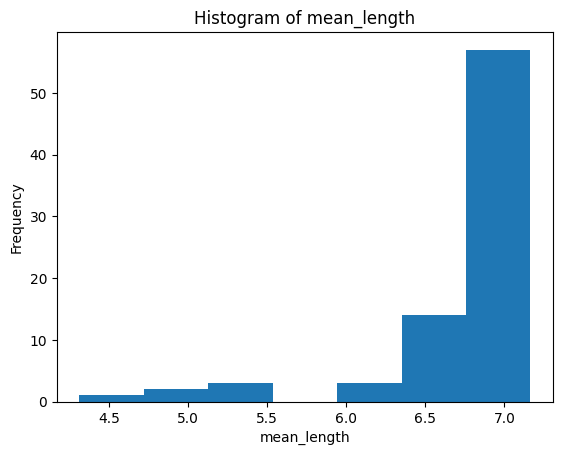

breaks,counts,mids_true,mids,widths
4.1075,nan,nan,nan,nan
4.515,1,1.85,4.31125,0.4075
4.9225,2,2.11,4.71875,0.4075
5.33,3,2.3,5.12625,0.4075
5.7375,0,0,5.53375,0.4075
6.145,3,2.75,5.94125,0.4075
6.5525,14,2.9,6.34875,0.4075
6.96,57,3.08,6.75625,0.4075


In [63]:
isolation_model.predict(training_data)["mean_length"].hist()

In [59]:
training_data

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128
0,0.0698272,0.306993,0.04405,0,0.426691,0.595628,0,0,0,0,1.18636,0,1.18098,0.495024,0.460184,0.499608,0,0,0.75192,0,0.84204,1.55551,2.01877,0,0,0,0.158009,0,0,0.446203,0.0933189,0.167921,0,0,5.52953,0.460558,0,0.328253,3.83551,0.00504842,0,0,0.0360659,0,0,0.707874,0.269694,0,0.542965,0.089092,0,0,0,0.534707,0,0,0.146969,0.527501,0,2.71255,0,0.137507,0,0,0,0.121751,0,0,0,0.326248,0.375971,0,0,0,0,0.469143,0.0611707,0,0,0.629414,0,0,0.285088,0.620849,0.439494,0.61764,0.106583,0,0,0.781445,1.03592,0,0,0,0,0,0.0298995,0,4.89025,0,3.17509,0.282107,0,0,0,0,0.134667,0,0.288569,0.0144012,0.0926712,1.44413,0,0,0,0,0.388608,0,0.15858,0.0845693,0,0,0,0,0,0,0
0,0.41522,0.0991732,0,0,0.325102,0,0,0,0,0,1.07654,0,1.71743,0,1.37389,1.6524,0,0,0.625879,0,0.686163,0,5.06604,0,0,0,0.333442,0.00916453,0,1.18383,0,0.0291407,0.612867,0,8.80351,0,0,0.226914,5.77327,0.0596697,0,0,0.534476,0,0.00482339,1.7143,1.74353,0,0.642094,0.519132,0,0,1.41908,0,0,0,0.364422,1.17592,0,5.55449,0,0,0,0,0,0,0,0,0,0,0.253093,0,0,0,0,0.0182689,0.447637,0,0,0.439383,0,0,0.202025,0,0.945621,0.547314,0,0,0.115966,0.139861,1.36208,0,0,0,0.600469,0,0,0,9.19076,0,2.93076,0,0,0,1.54244,0,1.07295,0,0.228279,0.0216979,0.146582,2.57739,0,0,0,0,0.0489632,0.187205,0,0.347122,0,0,0,0,0,0,0
0,0.454568,0,0,0,0.0606161,0,0,0.60843,0,1.16707,0.029802,0,2.01121,0,0,0,0.685647,0,0.501889,0,0.535324,0,5.11874,0,0,0,0.24273,0,0,1.30267,0.261081,0.464843,0,0.714827,6.07738,0,0.0433508,0.290062,3.99001,0,0.763076,0.0804746,0,0.239726,0,1.65731,0,0,0.432289,1.24375,1.63512,0.216358,0,0.126525,0,0,1.00376,0.166802,0,3.97883,0,0,0,0.569745,0,0.244266,0,0,0,0,0.501,0,0,0,0,0.0713582,0,3.17775,0.985195,0.958307,0,0,0.2955,0.859047,0.100762,1.43895,0.0193541,0,0.0438682,0.306054,0.607364,0,0,0,0,0,0.211737,0,6.92488,2.54551,0,0.967928,0,0,0.313903,0,0.627879,0,0.121157,0,0,1.77923,0.128452,0,0,0,1.46305,0,0.258648,0,0.0602018,0,0,0,2.10851,0,0
0,0.481324,0.353771,0,0,0.558147,0,0,0,0,0,0.850789,0,2.01135,0,0.582335,0.723308,0,0,0.435568,0,0.651426,1.99909,2.2338,0,0,0,0.175045,0,0,0.410498,0.14112,0.13197,0.305496,0,5.39402,0.319256,0,0.120933,3.90915,0,0,0,0.0213521,0,0.589124,0.817949,0.136368,0,0.668238,0.275137,0,0,0.410792,0.201116,0,0,0,0.56326,0,2.96718,0,0,0,0,0,0.0582323,0,0,0,0,0.638014,0.229117,0,0,0,0.257526,0.215169,0,0,0.695202,0,0,0.324878,0,1.01706,0.729401,0,0,0.131618,0.52207,0.83331,0,0,0,0,0,0.036904,0,5.66435,0,3.36563,0,0,0,0.0597633,0,0.514385,0,0.217228,0,0.774273,0.749787,0,0,0.0150722,0,0.206602,0,0.148753,0.372738,0,0.310124,0,0,0,0,0.163593
0,0.190001,0.0378474,0,0,0.266001,0.189447,0,0,0.92938,0,0.933663,0,1.1856,4.22467,0.986934,0,0,0,0,0.345023,0,0,2.24073,0,0,0,0.562836,0.425553,0,0.739351,0,0.132101,0,0,4.21663,0,0.725134,0.316277,3.03625,0,0,0,0,0.241485,0,1.11353,0,1.55827,0.503662,0.298775,0.100226,0.139262,0,0.352458,0,0,0.706831,0.922776,0,2.09061,0,0,0,0,0,0.364091,0.144089,0,0.530773,7.90312,0.42586,0,0,0.667421,1.41137,0.732316,0.108986,0,0.146846,0.301378,1.3851,0,0.130829,0,0.158774,0.948151,0.192117,0,0,0.496107,0.671594,0,0.0497577,0,0,0,0.732014,0,4.9741,0.504665,0.854555,0.3889,0,0,0,0,0,0,0.228083,0.0453878,0,1.14856,0.0128624,0,0,1.55139,0.556274,0,1.37365,0.114198,0.142922,0.0966213,0.77054,0,0,0,0
0.162394,0.834912,0.0747848,0,0,0.103322,0,0,0,0,0.0535232,0.108279,0,3.87064,0,0,0.449833,0.542718,0,0,0.305175,0.0506558,1.56743,1.6389,0,0,0,0.437749,0,0,0.610779,0.0872247,0.316805,0,0,3.74115,0.175761,0,0.353469,2.99318,0.533